In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [157]:
df = pd.read_csv('../Health.csv')
df.shape

(170761, 42)

In [145]:
# тут я выводил количество nan, оказались они только в 1 столбце(верьте мне)
df.isna().sum();

In [146]:
df.duplicated().sum()

0

In [166]:
missing_codes = ['.', '.d', '.r', '.x', '.q', '.u', '.v', '.s', '.m']
cnt_missing = 0

for col in df.columns:
    values = df[col].value_counts()

    for code in missing_codes:
        if code in values:
            cnt_missing += values[code]

print(cnt_missing)

75232


In [ ]:
print(f'Процент пропущенных: {(cnt_missing / (df.shape[0] * df.shape[1]) * 100):.2f}%')

In [147]:
df[df['sagey_b'].isna()]

,hhidpn,rmstat,ragender,rahispan,raracem,riwbegy,ragey_b,sagey_b,rhltc,rhlthlm,...,rjcten,index_wave,insured_gov,uninsured,retired,collegeplus,year,cpi,rgov,sgov
40359,42633021,1,1,0,3,15apr2006,53,NaN,3,1,...,.w,8,1,0,0,0,2005,1.133913,4680.0,10032.0
48942,48544011,1,1,0,1,15oct2006,46,NaN,3,1,...,1.9,8,0,0,0,0,2005,1.133913,0.0,0.0
85784,85066011,1,1,0,2,15apr2006,68,NaN,3,0,...,.w,8,1,0,100,0,2005,1.133913,7476.0,276.0
149436,500893010,3,2,0,1,15may2006,54,NaN,4,0,...,26.7,2,0,0,0,1,2005,1.133913,0.0,0.0


In [148]:
df['sagey_b'].fillna('.r', inplace=True) # будем считать, что те 4 человека отказались от ответа

In [21]:
df['rgov'].describe()

count    170761.000000
mean       6545.835385
std        7697.727228
min           0.000000
25%           0.000000
50%        5208.233900
75%       11346.187000
max      112269.450000
Name: rgov, dtype: float64

In [55]:
not_cat = ['inter_year', 'ragey_b', 'sagey_b', 'rhspnit', 'oop_spend', 'riearn', 'siearn', 'ripena', 'sipena', 'rgov', 'sgov', 'rjweeks', 'rjweek2', 'rjcten']

In [54]:
df['riwbegy'] = pd.to_datetime(df['riwbegy'])
df['inter_year'] = df['riwbegy'].dt.year

In [56]:
df[not_cat].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170761 entries, 0 to 170760
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   inter_year  170761 non-null  int64  
 1   ragey_b     170761 non-null  int64  
 2   sagey_b     170761 non-null  int64  
 3   rhspnit     170761 non-null  int64  
 4   oop_spend   170761 non-null  float64
 5   riearn      170761 non-null  float64
 6   siearn      170761 non-null  float64
 7   ripena      170761 non-null  float64
 8   sipena      170761 non-null  float64
 9   rgov        170761 non-null  float64
 10  sgov        170761 non-null  float64
 11  rjweeks     170761 non-null  float64
 12  rjweek2     170761 non-null  float64
 13  rjcten      170761 non-null  float64
dtypes: float64(10), int64(4)
memory usage: 18.2 MB


In [46]:
def to_int(el):
    try:
        return int(el)
    except ValueError:
        # print(el)
        return np.nan


def check_for_missing(el):
    try:
        _ = int(el)
        return 'OK'
    except ValueError:
        # print(el)
        return el

In [49]:
df['ragey_b'] = df['ragey_b'].apply(to_int)
df['sagey_b'] = df['sagey_b'].apply(to_int)
df['rhspnit'] = df['rhspnit'].apply(to_int)
df['rjweeks'] = df['rjweeks'].apply(to_int)
df['rjweek2'] = df['rjweek2'].apply(to_int)
df['rjcten'] = df['rjcten'].apply(to_int)

df['ragey_b'].fillna(df['ragey_b'].median(), inplace=True)
df['sagey_b'].fillna(df['sagey_b'].median(), inplace=True)
df['rhspnit'].fillna(df['rhspnit'].median(), inplace=True)
df['rjweeks'].fillna(df['rjweeks'].median(), inplace=True)
df['rjweek2'].fillna(df['rjweek2'].median(), inplace=True)
df['rjcten'].fillna(df['rjcten'].median(), inplace=True)

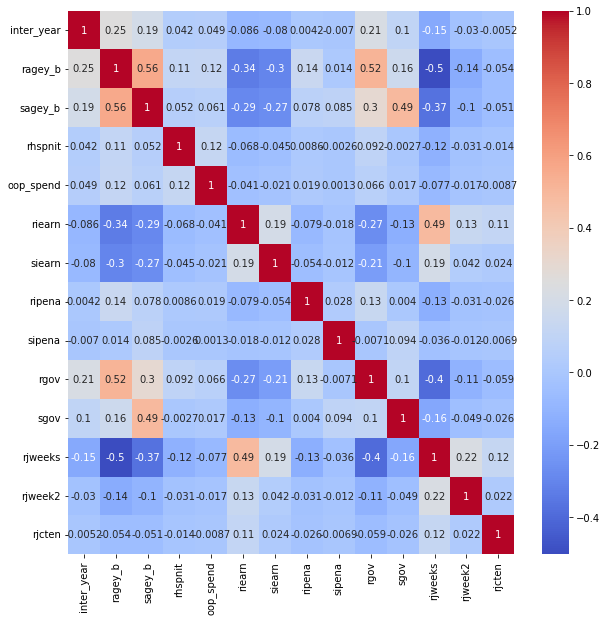

In [57]:
# get corr of not_cat columns from df
corr = df[not_cat].corr()

plt.figure(figsize=(10, 10))

sns.heatmap(corr, annot=True, cmap='coolwarm')

plt.show()

In [26]:
# надо будет подумать, являются ли эти данные выбросами(скорее нет)
df['sgov'].describe()

count    170761.000000
mean       3856.876258
std        7071.853159
min           0.000000
25%           0.000000
50%           0.000000
75%        6492.137200
max      159528.700000
Name: sgov, dtype: float64

In [162]:
import datetime

months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

def parse_date(el):
    day, month, year = el[:2], el[2:5], el[5:]

    return datetime.date(int(year), months.index(month) + 1, int(day))


df['riwbegy'] = df['riwbegy'].apply(parse_date)

In [159]:
df_without_missed_ragey_b = df[df['ragey_b'] != '.m'];
df_without_missed_ragey_b['ragey_b'] = df_without_missed_ragey_b['ragey_b'].astype(int);

median_age_by_wave = df_without_missed_ragey_b.groupby('index_wave')['ragey_b'].median();

In [160]:
def fill_missing_ragey_b(el):
    if el['ragey_b'] == '.m':
        return median_age_by_wave[el['index_wave']]
    else:
        return el['ragey_b']

df['ragey_b'] = df.apply(fill_missing_ragey_b, axis=1)
df['ragey_b'] = df['ragey_b'].astype(int)

df['year_of_birth'] = df['year'] - df['ragey_b']

In [163]:
# get year from riwbegy column
df['year_of_interview'] = df['riwbegy'].apply(lambda x: x.year)

# get year of birth
df['year_of_birth'] = df.apply(lambda x: x.year_of_interview - x.ragey_b, axis=1)

In [164]:
df['total_work_earn'] = df['riearn'] + df['siearn']
df['total_pension_earn'] = df['ripena'] + df['sipena']
df['total_gov_income'] = df['rgov'] + df['sgov']

df['total_income'] = df['total_work_earn'] + df['total_pension_earn'] + df['total_gov_income']

In [165]:
df['total_income'].describe()

count    1.707610e+05
mean     4.449124e+04
std      5.282410e+04
min      0.000000e+00
25%      1.519674e+04
50%      2.991608e+04
75%      5.718045e+04
max      6.875386e+06
Name: total_income, dtype: float64

In [27]:
# а тут меня очень смущает максимум в столбце sipena, мб это выброс
df.iloc[:, 21:25].describe()

,riearn,ripena,siearn,sipena
count,170761.000000,170761.000000,170761.000000,1.707610e+05
mean,15702.244733,3764.862189,12042.235232,2.579190e+03
std,33371.000325,12092.210896,30816.336503,2.217670e+04
min,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000,0.000000,0.000000,0.000000e+00
50%,0.000000,0.000000,0.000000,0.000000e+00
75%,21089.415692,0.000000,8000.000000,0.000000e+00
max,643233.038611,319329.942983,615098.104813,6.780589e+06


In [171]:
df.to_csv('../Health_cleaned.csv', index=False)